In [ ]:
from pathlib import Path
import requests

    1. Path and request module are used for fetching data from src.
    2. The data is a zip file which contains the MNIST dataset in
       pickle format.
    3. Pickle format is used for serializing data(binary stream)
       objects in python.

In [ ]:
DATA_PATH = Path("data")
PATH = DATA_PATH / "mnist"

PATH.mkdir( parents=True, exist_ok = True )

URL = "https://github.com/pytorch/tutorials/raw/master/_static/"
FILENAME = "mnist.pkl.gz"

if not (PATH / FILENAME).exists():

    content = requests.get(URL+FILENAME).content
    (PATH / FILENAME).open("wb").write(content)

Here we use gzip and pickle module to unzip and access the dataset.

In [ ]:
import pickle
import gzip

with gzip.open((PATH / FILENAME).as_posix(),"rb") as f:
        ((x_train,y_train) ,(x_valid,y_valid),_) = pickle.load(f,
            encoding= "latin-1")


    1. The dataset are pixels of images but they are stored as a
       flattened single vector or array with 784(28*28) columns or
       entries. 
    2. Inorder to plot the image we need to reshape it to 2D.
    3. There are 50,000 images or instances.

(50000, 784)


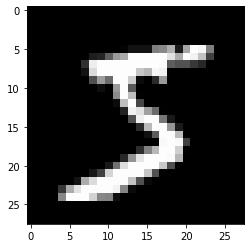

In [ ]:
from matplotlib import pyplot
import numpy as np

pyplot.imshow(x_train[0].reshape(28,28),cmap = "gray")
print(x_train.shape)

1. PyTorch works on torch.tensor data-objects but our data is an
   array. Hence we need to construct tensor object from our dataset.
2. Torch.tensor is a module which does this,  hence we use map and
   (tensor module & corresponding array objects) to replace the array
   storing variables with tensor objects. 

In [ ]:
import torch

x_train , Y_train , x_valid , y_valid = map(
        torch.tensor , (x_train,y_train,x_valid,y_valid)
)
n,c = x_train.shape

print(x_train,y_train)
print(x_train.shape)
print(y_train.min(),y_train.max())

tensor([[0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        ...,
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.]]) [5 0 4 ... 8 4 8]
torch.Size([50000, 784])
0 9


## Model (with tensor operations)

### Initializing weights &amp; biases

Dimensions :

   1. x (feature-vector) : (64,784) (instances , features or pixels)
   2. y (Label) : (64,1) (instances , labels)
   3. W (weights) : (784,10) ( features or x[1] , neurons in layer)
   4. b (bias) : (1,10)
   5. Z (activation) : (1,10)    

In [ ]:
import math

weights = torch.randn(784,10) / math.sqrt(784)
weights.requires_grad_()
bias = torch.zeros(10,requires_grad= True)

### Activation Function

1. What we're doing here is basically building a neural net for a classification problem with 10 outputs (0-9).
2. This doesn't have hidden layers.
3. The activation function used here is log-softmax.
4. This provides probability of each class for a input/instance.



In [ ]:
def log_softmax(x):
    return x - x.exp().sum(-1).log().unsqueeze(-1)

def model(xb):
    return log_softmax(xb @ weights + bias)

In [ ]:
bs = 64

xb = x_train[0:bs]
preds = model(xb)
preds[0] , preds.shape
print(preds[0],preds.shape)

tensor([-2.5562, -2.2111, -1.8952, -2.5964, -2.6124, -2.1189, -2.3035, -2.6178,
        -2.1590, -2.2430], grad_fn=<SelectBackward>) torch.Size([64, 10])


### Loss Function

In [ ]:
def nll( g,target):
    return -g[range(target.shape[0]), target].mean()
    

loss_func = nll

In [ ]:
yb = y_train[0:bs]
print(loss_func(preds,yb))

tensor(2.2798, grad_fn=<NegBackward>)


In [ ]:
preds

tensor([[-2.5562, -2.2111, -1.8952, -2.5964, -2.6124, -2.1189, -2.3035, -2.6178,
         -2.1590, -2.2430],
        [-2.7586, -2.6925, -1.9964, -2.7765, -2.3301, -2.1970, -2.4888, -2.6675,
         -1.5361, -2.3564],
        [-2.6596, -1.9952, -2.4353, -2.2511, -2.2621, -2.3318, -2.7089, -2.1014,
         -2.5214, -2.0348],
        [-2.6024, -2.0837, -2.4069, -2.2709, -2.3442, -2.3552, -2.2429, -2.1046,
         -2.2500, -2.4783],
        [-2.9204, -2.0508, -2.3804, -2.1732, -2.5130, -2.3009, -2.3271, -2.6847,
         -2.0894, -1.9635],
        [-2.8741, -2.3547, -1.7631, -1.9870, -2.4638, -2.5766, -2.4247, -3.0592,
         -2.3770, -1.8931],
        [-2.5960, -2.1625, -2.1830, -2.1045, -2.6041, -2.4613, -2.0905, -2.2671,
         -2.6210, -2.1496],
        [-2.6323, -2.5081, -2.0236, -1.9423, -2.4428, -2.2301, -2.7629, -2.3267,
         -2.1052, -2.3631],
        [-2.6332, -2.0945, -2.3571, -2.1768, -2.5818, -2.2897, -2.0709, -2.3575,
         -2.5032, -2.1419],
        [-2.8086, -

In [ ]:
-preds[range(0,64),0]

tensor([2.5562, 2.7586, 2.6596, 2.6024, 2.9204, 2.8741, 2.5960, 2.6323, 2.6332,
        2.8086, 2.6119, 2.7904, 2.5528, 2.9885, 2.6083, 2.6440, 2.5767, 2.8322,
        2.3620, 2.7756, 2.8066, 2.7850, 2.4492, 2.6514, 2.7842, 2.7646, 2.5746,
        2.6270, 2.9358, 2.6618, 2.8016, 2.7621, 2.4078, 2.6411, 2.6892, 2.6307,
        2.5079, 2.9145, 2.5572, 2.6950, 2.4261, 2.7995, 2.6882, 2.5125, 2.3682,
        2.8363, 2.6179, 2.9735, 2.7597, 2.5202, 2.2873, 2.8338, 2.8203, 2.7741,
        3.1909, 2.8302, 2.8421, 2.6991, 2.6401, 2.6094, 2.7031, 2.5443, 2.6369,
        2.4674], grad_fn=<NegBackward>)

<a style='text-decoration:none;line-height:16px;display:flex;color:#5B5B62;padding:10px;justify-content:end;' href='https://deepnote.com?utm_source=created-in-deepnote-cell&projectId=1b0fc471-afe9-40dd-afe8-89e46e68c6e6' target="_blank">
 </img>
Created in <span style='font-weight:600;margin-left:4px;'>Deepnote</span></a>